In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from custom_causal_inference import CustomCausalInference
import utils
import forward_models_causal_inference
import matplotlib.pyplot as plt
import pickle

In [2]:
%reload_ext autoreload

In [3]:
D = 250  # grid dimension 
NUM_SIM = 10000  # number of simulations
angle_gam_data_path = './base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='./uniform_model_base_inv_kappa_free.pkl'
p_commons = np.linspace(0, 1, num=20)
t_index = 0

causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
    model=CustomCausalInference(decision_rule='mean'),
    angle_gam_data_path=angle_gam_data_path,
    unif_fn_data_path=unif_fn_data_path)
unif_map = causal_inference_estimator.unif_map

In [4]:
grid_sz = 100
optimal_kappa_pairs_filepath = f'./learned_data/optimal_kappa_pairs_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_pc_filepath = f'./learned_data/min_error_for_idx_pc_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_filepath = f'./learned_data/min_error_for_idx_{grid_sz}_t{t_index}.pkl'
s_ns_filepath = f'./learned_data/selected_s_n_{grid_sz}_t{t_index}.npy'
ts_filepath = f'./learned_data/selected_t_{grid_sz}_t{t_index}.npy'
r_ns_filepath = f'./learned_data/selected_r_n_{grid_sz}_t{t_index}.npy'

In [5]:
with open(optimal_kappa_pairs_filepath, 'rb') as f:
    optimal_kappa_pairs = pickle.load(f)
with open(min_error_for_idx_pc_filepath, 'rb') as f:
    min_error_for_idx_pc = pickle.load(f)
with open(min_error_for_idx_filepath, 'rb') as f:
    min_error_for_idx = pickle.load(f)
s_ns = np.load(s_ns_filepath)
ts = np.load(ts_filepath)
r_ns = np.load(r_ns_filepath)

In [6]:
grid_dim = int(np.sqrt(s_ns.shape[0]))
grid_dim

10

In [ ]:
plt.scatter(s_ns, r_ns, label = 'r_n as fn of s_n')
#plt.scatter(ts, r_ns, label='r_n as fn of t')
plt.plot(s_ns, s_ns, label='s_n', c='r')
plt.legend()
plt.savefig(f'./figs/sn_vs_rn_{grid_sz}_t{t_index}.png')
plt.clf()
plt.scatter(np.linspace(np.min(s_ns), np.max(s_ns), num=grid_dim), s_ns[:grid_dim])
plt.title('Selected s_n as a function of uniform stimuli in angle space')
plt.savefig(f'./figs/selected_sn_{grid_sz}_t{t_index}.png')
plt.clf()

In [59]:
err_mat = {est: np.zeros_like(s_ns) for est in min_error_for_idx.keys()}
min_err_mat = np.zeros_like(s_ns)
optimal_kappa_pairs_arr = {est: np.zeros((*s_ns.shape, 2)) for est in optimal_kappa_pairs.keys()} # 2 kappa values
optimal_pc = {est: np.zeros_like(s_ns) for est in min_error_for_idx.keys()}
optimal_pc_min = np.zeros_like(s_ns)
err_threshold = np.deg2rad(5)

test_fwd_sim = True
fwd_errors = np.zeros_like(s_ns)
high_error_idxs = {'sn': [], 't': []}
for est in optimal_kappa_pairs.keys():
    for key in min_error_for_idx_pc[est]:
        if min_error_for_idx_pc[est][key] == min_error_for_idx[est][key[0]]:
            # key[0] is the index of means s.t. causal inference is performed on (s_n[key[0]], t[key[0]])
            # key[1] is the optimal p_common for the pair
            optimal_pc[est][key[0]] = key[1]
            err_mat[est][int(key[0])] = min_error_for_idx[est][key[0]]
            optimal_kappa_pairs_arr[est][int(key[0]), :] = np.array(optimal_kappa_pairs[est][key]).reshape(2,)
            if min_error_for_idx_pc[est][key] >= err_threshold:
                high_error_idxs[est].append(key[0])
                print(f'{key[0]}: t, s_n, r_n = {np.round(s_ns[key[0]], 3), np.round(ts[key[0]], 3), np.round(r_ns[key[0]], 4)}', 
                    f'd/pi={np.round(utils.circular_dist(s_ns[key[0]], ts[key[0]]) / np.pi, 4)}', 
                    f'min_err={min_error_for_idx_pc[est][key]}',  
                    f'p_c={np.round(key[1], 3)}', 
                    f'optimal_kappa={optimal_kappa_pairs[est][key]}')
            if test_fwd_sim:
                mean_ests = []
                for _ in range(30):
                    usn, ut = unif_map.angle_space_to_unif_space([s_ns[key[0]]]), unif_map.angle_space_to_unif_space([ts[key[0]]])
                    t_samples, s_n_samples = causal_inference_estimator.get_vm_samples(
                                num_sim=10000,
                                mu_t=ut,
                                mu_s_n=usn,
                                kappa1=optimal_kappa_pairs[est][key][0],
                                kappa2=optimal_kappa_pairs[est][key][1])
                    _, _, mean_t_est, mean_sn_est = causal_inference_estimator.forward(t_samples=t_samples,
                        s_n_samples=s_n_samples, 
                                                                            kappa1=optimal_kappa_pairs[est][key][0], 
                                                                            kappa2=optimal_kappa_pairs[est][key][1], 
                                                                            p_common=key[1])
                    if est == 'sn':
                        mean_ests.append(mean_sn_est[0,0])
                    else:
                        mean_ests.append(mean_t_est[0,0])
                    assert mean_sn_est.shape == (1, 1)
                del t_samples, s_n_samples, mean_t_est, mean_sn_est
                fwd_errors[key[0]] = sum(map(lambda x: utils.circular_dist(x, r_ns[key[0]]), mean_ests)) / len(mean_ests)
                if (np.rad2deg(utils.circular_dist(max(mean_ests), min(mean_ests))) > 2):
                    print('Max dif across 10 estimates for index', key, np.rad2deg(utils.circular_dist(max(mean_ests), min(mean_ests))))
                if abs(fwd_errors[key[0]] - min_error_for_idx_pc[est][key]) > err_threshold:
                    print(f'Error forward vs fits {key[0]}', fwd_errors[key[0]], np.rad2deg(abs(fwd_errors[key[0]] - min_error_for_idx_pc[est][key])), np.rad2deg(utils.circular_dist(max(mean_ests), min(mean_ests))))


31: t, s_n, r_n = (-1.274, -0.694, -0.5054) d/pi=0.1847 min_err=0.16620621476297304 p_c=0.895 optimal_kappa=(array([400.]), array([1.1]))
32: t, s_n, r_n = (-0.971, -0.694, -0.3778) d/pi=0.0884 min_err=0.28996344957419495 p_c=0.895 optimal_kappa=(array([400.]), array([1.1]))
33: t, s_n, r_n = (-0.694, -0.694, -0.3649) d/pi=0.0 min_err=0.29013045386387315 p_c=0.842 optimal_kappa=(array([291.81624545]), array([1.1]))
34: t, s_n, r_n = (-0.517, -0.694, -0.3803) d/pi=0.0562 min_err=0.1519011371940664 p_c=0.0 optimal_kappa=(array([32.09636014]), array([200.2]))
41: t, s_n, r_n = (-1.274, -0.517, -0.2964) d/pi=0.241 min_err=0.2231142337559735 p_c=0.947 optimal_kappa=(array([400.]), array([1.1]))
42: t, s_n, r_n = (-0.971, -0.517, -0.1256) d/pi=0.1446 min_err=0.3905482690815374 p_c=0.947 optimal_kappa=(array([400.]), array([1.1]))
43: t, s_n, r_n = (-0.694, -0.517, -0.173) d/pi=0.0562 min_err=0.3346169394168941 p_c=0.895 optimal_kappa=(array([400.]), array([1.1]))
44: t, s_n, r_n = (-0.517, -

In [12]:
for est in optimal_kappa_pairs_arr.keys():
    print(f'Indices for {est} where optimal kappa1 > kappa2: {np.sum(optimal_kappa_pairs_arr[est][:, 0] >= optimal_kappa_pairs_arr[est][:, 1])} {optimal_kappa_pairs_arr[est][:, 0] >= optimal_kappa_pairs_arr[est][:, 1]}')

Indices for sn where optimal kappa1 > kappa2: 91 [False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False  True  True  True  True  True  True  True  True False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True]
Indices for t where optimal kappa1 > kappa2: 42 [ True False False  True  True  True False  True False  True False False
  True False False  True  True  True False  True  True  True False False
 False False False False False False False  True  True False False False
 False False False False False  True  True  True False False False False
 

In [13]:
for est in optimal_kappa_pairs_arr.keys():
    print(f'Kappa values for estimate {est} where optimal kappa1 > kappa2: {optimal_kappa_pairs_arr[est][optimal_kappa_pairs_arr[est][:, 0] >= optimal_kappa_pairs_arr[est][:, 1]]}')

Kappa values for estimate sn where optimal kappa1 > kappa2: [[  6.6328955    2.50176241]
 [113.30729922   7.48256615]
 [212.89180278  50.89890563]
 [291.81624545   4.32661562]
 [212.89180278   3.29000977]
 [400.           1.90236977]
 [ 23.41559827   1.1       ]
 [ 60.305488     1.90236977]
 [400.           1.1       ]
 [113.30729922   1.1       ]
 [400.           4.32661562]
 [  4.83896665   1.1       ]
 [  4.83896665   1.1       ]
 [ 43.99530272   1.90236977]
 [113.30729922   1.44658451]
 [ 32.09636014   2.50176241]
 [  2.57544084   1.44658451]
 [291.81624545 200.2       ]
 [291.81624545   1.1       ]
 [291.81624545   1.1       ]
 [ 43.99530272   1.1       ]
 [  6.6328955    5.68983195]
 [  9.09187971   4.32661562]
 [ 43.99530272   5.68983195]
 [ 23.41559827   1.44658451]
 [ 82.6622766    1.44658451]
 [155.31321644   7.48256615]
 [ 23.41559827   3.29000977]
 [291.81624545   1.44658451]
 [400.           1.1       ]
 [400.           1.1       ]
 [291.81624545   1.1       ]
 [ 43.995302

In [10]:
usns = unif_map.angle_space_to_unif_space(s_ns)
uts = unif_map.angle_space_to_unif_space(ts)
for est in ['sn', 't']:
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
                err_mat[est].reshape((grid_dim, grid_dim)), shading='auto', cmap='magma')
    plt.colorbar(label='circular distance to r_n(t, s_n)')
    plt.xlabel('s_n')
    plt.ylabel('t')
    plt.title(f'Heatmap of error for r_n(t, s_n) using estimate for {est}')
    plt.savefig(f'./figs/error_heatmap_uspace_{grid_sz}_t{t_index}_{est}.png')
    plt.clf()

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [16]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), 
               uts.reshape((grid_dim, grid_dim)), 
               r_ns.reshape((grid_dim, grid_dim)), shading='auto', cmap='magma')
plt.colorbar(label='r_n(t, s_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of r_n(t, s_n)')
plt.savefig(f'./figs/r_n_axis_u_space_{grid_sz}_t{t_index}.png')
plt.clf()

<Figure size 720x576 with 0 Axes>

In [19]:
for est in ['sn', 't']:
    optimal_kappa_ratio = optimal_kappa_pairs_arr[est][:, 1] / optimal_kappa_pairs_arr[est][:, 0]
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
                optimal_kappa_ratio.reshape((grid_dim, grid_dim)), shading='auto', cmap='RdBu')
    plt.colorbar(label='optimal_kappa_ratio(t, s_n)')
    plt.xlabel('us_n')
    plt.ylabel('ut')
    plt.title(f'Heatmap of kappa ratio using estimate for {est}')
    plt.savefig(f'./figs/optimal_kappa_ratio_{grid_sz}_t{t_index}_{est}.png')
    plt.clf()

    for k_index in [0, 1]:
        plt.figure(figsize=(10, 8))
        plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
                    optimal_kappa_pairs_arr[est][:, k_index].reshape((grid_dim, grid_dim)), shading='auto', cmap='RdBu')
        plt.colorbar(label='optimal_kappa_ratio(t, s_n)')
        plt.xlabel('us_n')
        plt.ylabel('ut')
        if k_index == 0:
            # plot latex doesn't support variables :(
            plt.title(f'Heatmap of $\kappa_1(t, s_n)$ for {est}')
        else:
            plt.title(f'Heatmap of $\kappa_2(t, s_n)$ for {est}')
        plt.savefig(f'./figs/kappa{k_index+1}_{grid_sz}_t{t_index}_{est}.png')
        plt.clf()

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [21]:
for est in ['sn', 't']:
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
                optimal_pc[est].reshape((grid_dim, grid_dim)), shading='auto', cmap='RdBu')
    plt.colorbar(label='p_common(ut, us_n)')
    plt.xlabel('s_n')
    plt.ylabel('t')
    plt.title('Heatmap of optimal p_common(ut, us_n) for {est} estimate')
    plt.savefig(f'./figs/p_common_{grid_sz}_t{t_index}_{est}.png')
    plt.clf()

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

## Looking at optimal $\kappa$ pairs

In [24]:
import os
print(os.getcwd())

d:\AK_Q2_2024\causal_inference


In [ ]:
import pickle

with open(f'./learned_data/task_metadata_{grid_sz}_t{t_index}.pkl', 'rb') as f:
    tasks_metadata = pickle.load(f)
num_tasks = len(tasks_metadata)
print(f'Number of tasks: {num_tasks}')
errors_dicts = {}
estimates = ['sn', 't']
err_for_idx = {est: {} for est in estimates}
nums_bad = 0
max_error = 0
high_error_idxs_both_est = []
for task_idx in range(num_tasks):
    try:
        with open(f'./learned_data/optimal_kappa_errors/errors_dict_{task_idx}_{grid_sz}_t{t_index}.pkl', 'rb') as f:
            errors_dicts[task_idx] = pickle.load(f)
            mean_idx = tasks_metadata[task_idx]['mean_indices'][0]
            min_error_across_pc = {est: min([errors_dicts[task_idx][p_c][f'errors_{est}'].min() for p_c in errors_dicts[task_idx].keys()]) for est in estimates}
            for est in estimates:
                if mean_idx not in err_for_idx[est]:
                    err_for_idx[est][mean_idx] = min_error_across_pc[est]
                else:   
                    err_for_idx[est][mean_idx] = min(err_for_idx[est][mean_idx], min_error_across_pc[est])
    except:
        nums_bad += 1
        print(f'Error for task {task_idx}')
print(f'Number of bad tasks: {nums_bad}')
for mean_idx in err_for_idx:
    if max(err_for_idx['sn'][mean_idx], err_for_idx['t'][mean_idx]) > .1:
        high_error_idxs_both_est.append(mean_idx)
        print(mean_idx, err_for_idx['sn'][mean_idx], err_for_idx['t'][mean_idx])
    max_error = max(min(err_for_idx['sn'][mean_idx], err_for_idx['t'][mean_idx]), max_error)
print(f'Max error: {max_error}')
print(high_error_idxs_both_est, '\n', list(zip(zip(s_ns[high_error_idxs_both_est], ts[high_error_idxs_both_est]), r_ns[high_error_idxs_both_est])))

In [56]:
errors_dicts[31][1.0]['errors_t'], errors_dicts[31][0.0]['errors_t']

(array([0.19563274, 0.19598604, 0.19631347, 0.19665918, 0.19673722,
        0.1968979 , 0.19721252, 0.19869965, 0.19881868, 0.19926838,
        0.19990927, 0.20005809, 0.20033883, 0.20078802, 0.20144288,
        0.20243064, 0.20277238, 0.20303619, 0.20364949, 0.2042045 ,
        0.20421627, 0.20430951, 0.20619348, 0.20719559, 0.20738809,
        0.2077417 , 0.20787446, 0.20793327, 0.21045564, 0.21104438,
        0.21107835, 0.21141673, 0.21199547, 0.21239549, 0.21259792,
        0.21353929, 0.21424537, 0.21500496, 0.21599415, 0.21807018,
        0.21920487, 0.21979079, 0.21985055, 0.21985951, 0.22088799,
        0.22158222, 0.22204387, 0.22224587, 0.22371694, 0.22456831]),
 array([0.19282693, 0.19303133, 0.19319377, 0.19335094, 0.19340313,
        0.19387955, 0.19392917, 0.19426232, 0.19432129, 0.19441968,
        0.1944834 , 0.1945377 , 0.19455852, 0.19456239, 0.19466761,
        0.19489024, 0.19494633, 0.19500842, 0.19533866, 0.19543327,
        0.19558772, 0.19559272, 0.19568996, 0.

### Analysis on pairs of stimuli with high errors

For index 31 with s_n, t, r_n = (-1.274300634588631, -0.6939260881423239, -0.5053799) and us_n, ut, urn = (-1.4033964984714, -1.039481147872558, -0.8713160334762415),
 optimal kappa pairs: (array([400. ,   1.1]), array([400.        ,  12.94055242])) and optimal p_c: (0.894736842105263, 0.0)




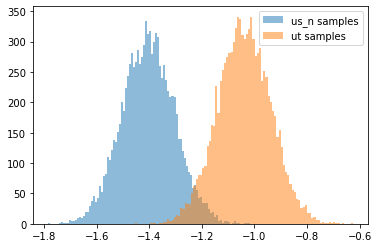

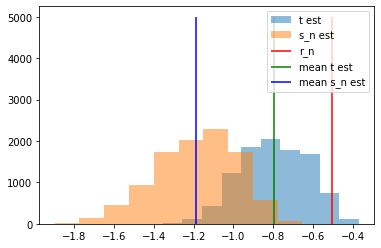

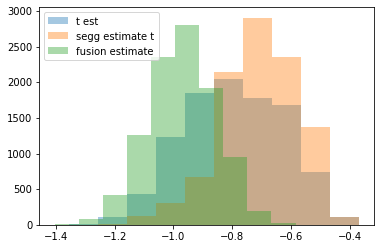

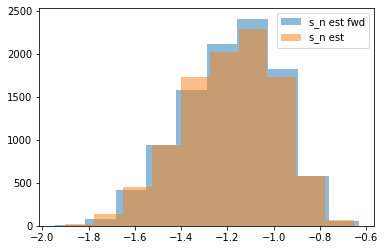

For index 32 with s_n, t, r_n = (-0.9714965233992534, -0.6939260881423239, -0.37781167) and us_n, ut, urn = (-1.221749956794178, -1.039481147872558, -0.6483995290204754),
 optimal kappa pairs: (array([400. ,   1.1]), array([400.        ,   3.29000977])) and optimal p_c: (0.894736842105263, 0.05263157894736842)




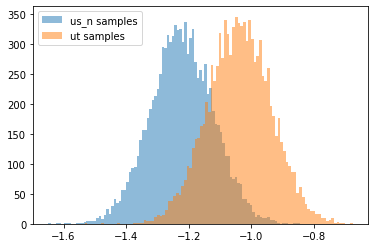

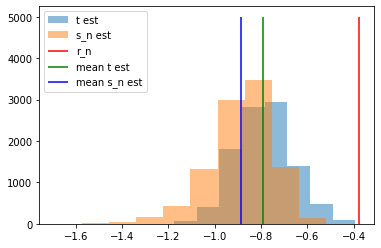

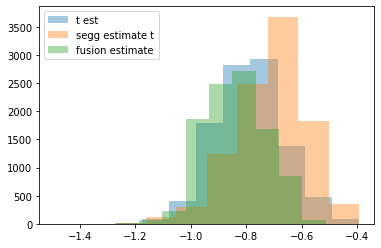

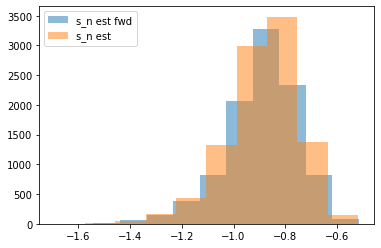

<Figure size 432x288 with 0 Axes>

In [ ]:
num_to_analyse = 2
est = 'sn'
for i in range(num_to_analyse):
    idx = high_error_idxs[est][i]
    sni, ti, rni = s_ns[idx], ts[idx], r_ns[idx]
    urni = unif_map.angle_space_to_unif_space(rni)
    usni, uti = usns[idx], uts[idx]
    assert (np.allclose(np.array([usni, uti]), unif_map.angle_space_to_unif_space([sni, ti])))
    optimal_kappa_pair_sn = optimal_kappa_pairs_arr['sn'][idx]
    optimal_kappa_pair_t = optimal_kappa_pairs_arr['t'][idx]
    pc_sn = optimal_pc['sn'][idx]
    pc_t = optimal_pc['t'][idx]
    print(f'For index {idx} with s_n, t, r_n = {sni, ti, rni} and us_n, ut, urn = {usni, uti, urni},\n optimal kappa pairs: {optimal_kappa_pair_sn, optimal_kappa_pair_t} and optimal p_c: {pc_sn, pc_t}\n\n')
    # 1. run VM samples of the 2 distributions and plot the distributions
    # kappa1, kappa2 = np.array([optimal_kappa_pair_sn[0]]), np.array([optimal_kappa_pair_sn[1]])
    # kappa1, kappa2 = np.array([700.]), np.array([1.])
    kappa1, kappa2, pc_i = np.array([100.]), np.array([99.]), .5
    ut_samples, usn_samples = causal_inference_estimator.get_vm_samples(
        num_sim=10000,
        mu_t=np.array([uti]),
        mu_s_n=np.array([usni]),
        kappa1=kappa1,
        kappa2=kappa2)
    plt.hist(usn_samples[:, 0,0], bins=100, alpha=0.5, label='us_n samples')
    plt.hist(ut_samples[:, 0,0], bins=100, alpha=0.5, label='ut samples')
    plt.legend()    
    plt.show()
    plt.clf()
    # 2. run Causal Inference in internal space for ut, us_n samples and plot the distributions of the optimal estimate for each sample
    responses, posterior_p_common, mean_t_est, mean_sn_est = causal_inference_estimator.forward(t_samples=ut_samples,
        s_n_samples=usn_samples, 
                                        kappa1=kappa1, 
                                        kappa2=kappa2, 
                                        p_common=pc_i)
    plt.hist(responses[0][:, 0,0], label='t est', alpha=.5)
    plt.hist(responses[1][:, 0, 0], label='s_n est', alpha=.5)
    plt.vlines(rni, 0, 5000, label='r_n', color='r')
    plt.vlines(mean_t_est[0,0], 0, 5000, label='mean t est', color='g')
    plt.vlines(mean_sn_est[0,0], 0, 5000, label='mean s_n est', color='b')
    plt.legend()    
    plt.show()
    plt.clf()
    # 3. for testing purpose: run Causal inference using means and other randomly generated samples
    responses_, posterior_p_common_, mean_t_est_, mean_sn_est_ = causal_inference_estimator.forward_from_means(mu_t=np.array([uti]),
                                                                                                               mu_s_n=np.array([usni]), 
                                        kappa1=kappa1, 
                                        kappa2=kappa2, 
                                        p_common=pc_i,
                                        num_sim=10000)
    plt.hist(responses[0][:, 0,0], label='t est', alpha=.4)
    # plt.hist(responses_[0][:, 0,0], label='t est fwd', alpha=.4)
    # 4. plot seggregated estimates for the regressor cue
    # 5. plot the cue combination estimates for all samples
    segg_estimate = causal_inference_estimator.model.segregation_estimate(x=ut_samples, sigma=kappa1, mu_p=None, sigma_p=None)
    fusion_estimate = causal_inference_estimator.model.fusion_estimate(x_v=ut_samples, x_a=usn_samples, 
                                                                       sigma_v=kappa1.reshape((1,1)), 
                                                                       sigma_a=kappa2.reshape((1,1)), 
                                                                       mu_p=None, sigma_p=None)
    plt.hist(segg_estimate[:, 0, 0], label='segg estimate t', alpha=.4)
    plt.hist(fusion_estimate[:, 0, 0], label='fusion estimate', alpha=.4)
    #plt.hist(unif_map.unif_space_to_angle_space(ut_samples)[:,0,0], label='U^{-1}(VM(t, kappa1))', alpha=.5)
    plt.legend()
    plt.show()
   
    plt.clf()
    # 6. plot the distribution of responses from the forward model vs the distribution of responses from the causal inference model above
    plt.hist(responses_[1][:, 0, 0], label='s_n est fwd', alpha=.5)
    plt.hist(responses[1][:, 0, 0], label='s_n est', alpha=.5)
    plt.legend()    
    plt.show()
    plt.clf()